In [1]:
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import xarray as xr

import healpix as hp

import easygems
import easygems.remap as egr
import easygems.healpix as egh

import dask
import dask.array as da

import zarr

import shutil

# notes
# -----
# - online sources suggest using healpy intead of healpix? 
#   + import healpy 
#   + Possibly healpix was added later and built on healpy.
#   + HEALPix documentation: https://healpix.sourceforge.io/documentation.php


In [2]:
print(f"Python Version: {sys.version}")
print(f"Numpy {np.__version__}")
print(f"Xarray {xr.__version__}")
print(f"Dask {dask.__version__}")

print(f"Healpix {hp.__version__}")
print(f"Zarr {zarr.__version__}")

print(f"EasyGems doesn't provide a version attribute.")


Python Version: 3.12.3 | packaged by conda-forge | (main, Apr 15 2024, 18:38:13) [GCC 12.3.0]
Numpy 2.1.3
Xarray 2025.1.2
Dask 2025.2.0
Healpix 2024.2
Zarr 3.0.5
EasyGems doesn't provide a version attribute.


In [3]:
# SET NECESSARY INPUT AND OUTPUT PATHS

# dataloc = Path("/glade/campaign/mmm/wmr/skamaroc/NSC_2023/3.75km_simulation_output_save")
dataloc = Path("/glade/derecho/scratch/brianpm/healpix")
datafil = dataloc / "diag.3.75km.2020-10-21_07.30.00.nc"

# mesh description (maybe)
meshloc = Path("/glade/campaign/mmm/wmr/skamaroc/NSC_2023")
meshfil = meshloc / "x1.41943042.static.nc"

# output location
oloc = Path("/glade/derecho/scratch/brianpm/healpix")


In [4]:
%%time
ds_mpas = xr.open_dataset(datafil, engine='netcdf4')
ds_static = xr.open_dataset(meshfil)

# Clean and convert xtime strings
time_str = ds_mpas.xtime.astype(str).values.astype('U').ravel()
# Remove extra whitespace and handle empty strings
time_str = [x.strip() for x in time_str]
time_str = [x.replace("_", " ") for x in time_str]

# Convert to datetime, handling potential errors
time_coord = pd.to_datetime(time_str)

# Create a new dataset with the correct time coordinate
ds_mpas_new = ds_mpas.assign_coords(time=('Time', time_coord))

# Rename the Time dimension to time
ds_mpas_new = ds_mpas_new.rename({'Time': 'time'})

# Find variables with dtype 'S64'
s64_vars = [var for var in ds_mpas_new.variables if ds_mpas_new[var].dtype == 'S64']
print(f"Variables with S64 dtype: {s64_vars}")

# Drop these variables from the dataset
ds_mpas_clean = ds_mpas_new.drop_vars(s64_vars)

Variables with S64 dtype: ['initial_time', 'xtime']
CPU times: user 532 ms, sys: 265 ms, total: 797 ms
Wall time: 1.66 s


<timed exec>:17: UserWarning: rename 'Time' to 'time' does not create an index anymore. Try using swap_dims instead or use set_index after rename to create an indexed coordinate.


In [6]:
# All the local functions that we need.

def remove_directory(inpath):
    """
    Removes a directory and its contents recursively.

    Args:
        path_str: Path to the directory as a string.
    """
    if isinstance(inpath, str):
        path = Path(inpath)
    else:
        path = inpath
    if path.exists():
        shutil.rmtree(path)
        print(f"Removed directory: {path}")
    else:
        print(f"Directory not found: {path}")


def get_mpas_lonlat(ds, lonname, latname, degrees=True, negative=True, verbose=False):
    '''Get latitude and longitude from MPAS "static" file,
       convert to degrees (default),
       convert to [-180, 180] convention (default)

    ds : xr.Dataset
        data set that needs to have lat and lon values
    latname : str
        name of the latitude variable
    lonname : str
        name of the longitude variable
    degrees : bool
        if true, convert to degrees (ASSUMES RADIANS)
    negative : bool
        if true, convert to -180 format if needed
        if false, convert to 360 format if needed
        Assumes unit is degrees, and the conversion is based on minimum longitude value being < 0 or maximum > 180
        Does not "roll" the coordinate (i.e. change the order of the longitudes)
    verbose : bool
        if true print stuff
    '''
    lonrad = ds[lonname]
    latrad = ds[latname]
    if verbose:
        print(f"Sizes: {lonrad.shape = }, {latrad.shape = } -- Compare with {ds_mpas['nCells'].shape}")
        print(f"[initial] Lat min/max: {latrad.min().item()}, {latrad.max().item()}, Lon min/max: {lonrad.min().item()},{lonrad.max().item()}")
    
    if degrees:
        # lon and lat are in radians
        lon = np.rad2deg(lonrad) 
        lat = np.rad2deg(latrad)

    if verbose:
        print(f"[degrees] Lat min/max: {lat.min().item()}, {lat.max().item()}, Lon min/max: {lon.min().item()},{lon.max().item()}")

    if negative:
        if lon.max().item() >= 180:
            lon=(lon + 180) % 360 - 180  # [-180, 180)
    else:
        if lon.min().item() < 0:
            lon += 180
    if verbose:
        print(f"[final] Lat min/max: {lat.min().item()}, {lat.max().item()}, Lon min/max: {lon.min().item()},{lon.max().item()}")
    return lon, lat


def get_weights_to_healpix(lon, lat, order, weights_file, overwrite=None):
    # nside determines the resolution of the map, generally a power of 2
    # zoom & order are just the exponent:
    # nside = 2**(zoom)

    # npix is just the number of "pixels" (grid points on HEALPix grid)
    zoom = order
    nside = hp.order2nside(order)
    npix = hp.nside2npix(nside)

    write = False
    if weights_file.is_file():
        if overwrite:
            write = True
            weights_file.unlink()
            print("Overwrite existing file.")
    else:
        write = True

    latlon = True

    print(f"The number of pixels is {npix}, based on {nside} = 2**{zoom}. WRITE: {write}. LATLON: {latlon}")

    if write:
        # gets the longitude and latitude of each
        # latlon: If True, input angles are assumed to be longitude and latitude in degree, otherwise, they are co-latitude and longitude in radians.
        hp_lon, hp_lat = hp.pix2ang(nside=nside, ipix=np.arange(npix), lonlat=latlon, nest=True)

        # WE NEED TO SHIFT LONGITUDE TO [-180,180] CONVENTION
        # Probably only if source does??
        if latlon and np.any(hp_lon > 180):
            hp_lon = (hp_lon + 180) % 360 - 180  # [-180, 180)
            hp_lon += 360 / (4 * nside) / 4  # shift quarter-width  ##???????##
            # source lon shift already applied using get_mpas_lonlat
        else:
            print(f"Will not modify hp_lon. Min/Max: {hp_lon.min().item()}, {hp_lon.max().item()} Size: {hp_lon.shape}")

        # easygems weight generation
        # If latlon=True above, then we probably want source in degrees
        eweights = egr.compute_weights_delaunay((lon, lat),(hp_lon, hp_lat))

        # save the calculated weights for future use    
        eweights.to_netcdf(weights_file)
        print(f"Weights file written: {weights_file.name}")
        return eweights
    else: 
        return xr.open_dataset(weights_file) 

    # NOTE: write=True takes a while: ~9min



def apply_weights_hp(ds, weights, order, mpas_v_c=None):
    """remap to healpix using easygems generated weights
    
    ds and weights should be consistent
    mpas_v_c determines if using "nCell" or "nVertices" variables
    """
    assert (mpas_v_c in ["center", "vertex"]), f"mpas_v_c must be center or vertex, got {mpas_v_c}"
    # repeat:
    zoom = order
    nside = hp.order2nside(order)
    npix = hp.nside2npix(nside)

    vertices_vars = []
    center_vars = []
    for v in ds:
        if 'nVertices' in ds[v].dims:
            vertices_vars.append(v)
        elif 'nCells' in ds[v].dims:
            center_vars.append(v)
    if mpas_v_c == "center":
        vars_to_drop = vertices_vars
        core_dims_list = ["nCells"]
    elif mpas_v_c == "vertex":
        vars_to_drop = center_vars
        core_dims_list = ["nVertices"]
    if vars_to_drop:
        ds_filter = ds.drop_vars(vars_to_drop)
    else:
        ds_filter = ds
    
    mpas_remap = xr.apply_ufunc(
        egr.apply_weights,
        ds_filter,
        kwargs=weights,
        keep_attrs=True,
        input_core_dims=[core_dims_list],
        output_core_dims=[["cell"]],
        on_missing_core_dim='copy',
        output_dtypes=["f4"],
        vectorize=True,
        dask="parallelized",
        dask_gufunc_kwargs={
            "output_sizes": {"cell": npix},
        },
    )
    return mpas_remap


def remap_mpas_to_hp(ds, cell_weights, vertex_weights, zoom):
    c_vars = apply_weights_hp(ds, cell_weights, zoom, mpas_v_c="center")
    v_vars = apply_weights_hp(ds, vertex_weights, zoom, mpas_v_c="vertex")
    mrg = xr.merge([c_vars, v_vars])

    # Add the CRS
    mrg["crs"] = xr.DataArray(
        name="crs",
        data=0,
        attrs={
            "grid_mapping_name": "healpix",
            "healpix_nside": 2**zoom,
            "healpix_order": "nest",
        },
    )
    return mrg

# Write to ZARR

def get_dtype(da):
    if np.issubdtype(da.dtype, np.floating):
        return "float32"
    else:
        return da.dtype

def get_encoding(dataset):
    return {
        var: {
            # "compressor": get_compressor(),
            "dtype": get_dtype(dataset[var]),
            # "chunks": get_chunks(dataset[var].dims),
        }
        for var in dataset.variables
        if var not in dataset.dims
    }


def save_to_zarr(ds, fn, clobber=None):
    if fn.exists():
        if clobber:
            print(f"{fn} exists... remove")
            do_save = True
            remove_directory(fn)
        else:
            print(f"{fn} exists... coarsen but do not save")
            do_save = False
    else:
        do_save = True
    if do_save:
        store = zarr.storage.LocalStore(fn)
        ds.chunk({"time": -1, "cell": -1}).to_zarr(store, encoding=get_encoding(ds))
        print(f'Saved: {str(fn)}')
    else:
        print('Determined not to save to zarr.')


def mpas_hp_to_zarr(ds, zoom, outloc, zarr_name_prefix, clobber=None):
    """Save to zarr at zoom and lower resolutions
    
    notes
    -----
    the iteration is from zoom-1 down to zero. Have to use
    zoom-1 because the computation is to coarsen from the "current"
    healpix level down to the next one.
    """
    dn=ds.copy()
    for x in range(zoom-1,0,-1):
        fn = outloc / f"{zarr_name_prefix}_to_hp{x}.zarr"

        # coarsen by one level
        dx = dn.coarsen(cell=4).mean()
        save_to_zarr(dx, fn, clobber=clobber)
        # iterate
        dn = dx.copy()
    print("[mpas_hp_to_zarr] complete.")

In [8]:
%%time

# Set parameters needed for generation weights:
zoom = 10

weights_file = oloc / f"mpas_to_healpix_weights_order{zoom}.nc"

vert_weights_file = oloc / f"mpas_to_healpix_vertex_weights_order{zoom}.nc"

out_prefix = "test3_mpas"

overwrite_weights = False

overwrite_zarr = True

def mpas_to_hp_zarr(data, grid_data, order, c_weights, v_weights, out_dir, zarr_prefix, clobber_wgts=None, clobber_zarr=None):
    # cell-center
    lon, lat = get_mpas_lonlat(grid_data, 'lonCell', 'latCell', degrees=True, negative=True, verbose=True)

    # generate or load weights
    eweights = get_weights_to_healpix(lon, lat, order, c_weights, overwrite=clobber_wgts)

    # MPAS files have variables at cell centers and vertices,
    # to remap them weights for each are needed:

    vlon, vlat = get_mpas_lonlat(grid_data, 'lonVertex', 'latVertex', degrees=True, negative=True, verbose=True)

    evweights = get_weights_to_healpix(vlon, vlat, order, v_weights, overwrite=clobber_wgts)

    dsout = remap_mpas_to_hp(data, eweights, evweights, order)

    # save highest resolution output
    fn = out_dir / f"{zarr_prefix}_to_hp{order}.zarr"
    save_to_zarr(dsout, fn, clobber=clobber_zarr)

    # now coarsen and save zarr
    mpas_hp_to_zarr(dsout, order, out_dir, zarr_prefix, clobber=clobber_zarr)


mpas_to_hp_zarr(ds_mpas_clean, ds_static, zoom, weights_file, vert_weights_file, oloc, out_prefix, clobber_wgts=False, clobber_zarr=True)


Sizes: lonrad.shape = (41943042,), latrad.shape = (41943042,) -- Compare with (41943042,)
[initial] Lat min/max: -1.5707963705062866, 1.5707963705062866, Lon min/max: 0.0,6.2831854820251465
[degrees] Lat min/max: -90.0, 90.0, Lon min/max: 0.0,360.0
[final] Lat min/max: -90.0, 90.0, Lon min/max: -180.0,179.98284912109375
The number of pixels is 12582912, based on 1024 = 2**10. WRITE: False. LATLON: True
Sizes: lonrad.shape = (83886080,), latrad.shape = (83886080,) -- Compare with (41943042,)
[initial] Lat min/max: -1.5704516172409058, 1.5704516172409058, Lon min/max: 0.0,6.2831854820251465
[degrees] Lat min/max: -89.9802474975586, 89.9802474975586, Lon min/max: 0.0,360.0
[final] Lat min/max: -89.9802474975586, 89.9802474975586, Lon min/max: -180.0,179.98941040039062
The number of pixels is 12582912, based on 1024 = 2**10. WRITE: False. LATLON: True
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp10.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/te

/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp10.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp9.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp9.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp9.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp8.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp8.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp8.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp7.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp7.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp7.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp6.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp6.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp6.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp5.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp5.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp5.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp4.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp4.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp4.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp3.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp3.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp3.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp2.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp2.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp2.zarr
/glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp1.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp1.zarr
Saved: /glade/derecho/scratch/brianpm/healpix/test3_mpas_to_hp1.zarr
[mpas_hp_to_zarr] complete.
CPU times: user 42.7 s, sys: 15.7 s, total: 58.3 s
Wall time: 58.5 s


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


In [ ]:
# mapping of variable names:
# mpas name : cmip name
vn_map = {
'initial_time':'',
'xtime':'',
'ivt':'',
'refl10cm_max':'',
'meanT_500_300':'',
'lh':'hflsd',
'hfx':'',
'olrtoa':'rlut',
'refl10cm_1km':'',
'precipw':'prw',
'u10':'uas',
'v10':'vas',
'q2':'huss',
't2m':'tas',
'cape':'',
'cin':'',
'rainc':'',
'rainnc':'',
'i_rainc':'',
'i_rainnc':'',
'mslp':'psl',
'liquid_water_path':'clwvi',
'ice_water_path':'clivi',
'relhum_200hPa':'',
'relhum_250hPa':'',
'relhum_500hPa':'',
'relhum_700hPa':'',
'relhum_850hPa':'',
'relhum_925hPa':'',
'temperature_200hPa':'',
'temperature_250hPa':'',
'temperature_500hPa':'',
'temperature_700hPa':'',
'temperature_850hPa':'',
'temperature_925hPa':'',
'height_200hPa':'',
'height_250hPa':'',
'height_500hPa':'',
'height_700hPa':'',
'height_850hPa':'',
'height_925hPa':'',
'uzonal_200hPa':'',
'uzonal_250hPa':'',
'uzonal_500hPa':'',
'uzonal_700hPa':'',
'uzonal_850hPa':'',
'uzonal_925hPa':'',
'umeridional_200hPa':'',
'umeridional_250hPa':'',
'umeridional_500hPa':'',
'umeridional_700hPa':'',
'umeridional_850hPa':'',
'umeridional_925hPa':'',
'w_200hPa':'',
'w_250hPa':'',
'w_500hPa':'',
'w_700hPa':'',
'w_850hPa':'',
'w_925hPa':'',
'vorticity_200hPa':'',
'vorticity_250hPa':'',
'vorticity_500hPa':'rva500',
'vorticity_700hPa':'',
'vorticity_850hPa':'rva850',
'vorticity_925hPa':'',
}

In [10]:
[print(f"{dvname}") for dvname in ds_mpas.data_vars]

initial_time
xtime
ivt
refl10cm_max
meanT_500_300
lh
hfx
olrtoa
refl10cm_1km
precipw
u10
v10
q2
t2m
cape
cin
rainc
rainnc
i_rainc
i_rainnc
mslp
liquid_water_path
ice_water_path
relhum_200hPa
relhum_250hPa
relhum_500hPa
relhum_700hPa
relhum_850hPa
relhum_925hPa
temperature_200hPa
temperature_250hPa
temperature_500hPa
temperature_700hPa
temperature_850hPa
temperature_925hPa
height_200hPa
height_250hPa
height_500hPa
height_700hPa
height_850hPa
height_925hPa
uzonal_200hPa
uzonal_250hPa
uzonal_500hPa
uzonal_700hPa
uzonal_850hPa
uzonal_925hPa
umeridional_200hPa
umeridional_250hPa
umeridional_500hPa
umeridional_700hPa
umeridional_850hPa
umeridional_925hPa
w_200hPa
w_250hPa
w_500hPa
w_700hPa
w_850hPa
w_925hPa
vorticity_200hPa
vorticity_250hPa
vorticity_500hPa
vorticity_700hPa
vorticity_850hPa
vorticity_925hPa


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [79]:
if eweights is None:
    print("Reload the weights file.")
    eweights = get_weights_to_healpix(lon, lat, zoom, weights_file, overwrite=False)

if evweights is None:
    print("Reload the vertex weights file.")
    evweights = get_weights_to_healpix(vlon, vlat, zoom, vert_weights_file, overwrite=False)

In [80]:
invalid = np.any(~eweights['valid']) # if all valid, then no need to do "custom indexing" ? 

if invalid:
    num_invalid = np.sum(~eweights['valid'])
    print(f"There are {num_invalid.item()} invalid weights, so you should mask the data before applying weights.")
    do_mask = True
else:
    print("All data can be weighted and remapped.")
    do_mask = False


invalid_v = np.any(~evweights['valid']) # if all valid, then no need to do "custom indexing" ? 

if invalid_v:
    print("There are invalid vertex weights, so you should mask the data before applying weights.")
    do_mask_v = True
else:
    print("All data can be weighted and remapped.")
    do_mask_v = False

There are 158 invalid weights, so you should mask the data before applying weights.
All data can be weighted and remapped.


In [27]:
%%time
c_vars = apply_weights_hp(ds_mpas, eweights, zoom, mpas_v_c="center")


CPU times: user 25.9 s, sys: 18.6 s, total: 44.5 s
Wall time: 44.5 s


In [28]:
%%time
v_vars = apply_weights_hp(ds_mpas, evweights, zoom, mpas_v_c="vertex")

CPU times: user 2.97 s, sys: 1.92 s, total: 4.89 s
Wall time: 4.89 s


In [ ]:
%%time

mrg = xr.merge([c_vars, v_vars])

# Add the CRS
mrg["crs"] = xr.DataArray(
    name="crs",
    data=0,
    attrs={
        "grid_mapping_name": "healpix",
        "healpix_nside": 2**zoom,
        "healpix_order": "nest",
    },
)


out_zarr = oloc / f"test_mpas_healpix_weights{zoom}.zarr"

if out_zarr.exists():
    print("out_zarr zarr store exists... try remove")
    remove_directory(out_zarr)
    
store = zarr.storage.LocalStore(out_zarr)

mrg.chunk({"Time": -1, "cell": -1}).to_zarr(store, encoding=get_encoding(mrg))
print(f"Saved the {zoom = } data. Next will coarsen.")

# save lower resolutions
dn=mrg.copy()
for x in range(zoom-1,0,-1):
    print(f"Will coarsen down to zoom = {x}")
    fn = oloc / f"test_remap_to_hp{x}.zarr"

    if fn.exists():
        print(f"{fn} exists... remove")
        remove_directory(fn)

    # coarsen by one level
    dx = dn.coarsen(cell=4).mean()
    
    store = zarr.storage.LocalStore(fn)
    dx.chunk({"Time": -1, "cell": -1}).to_zarr(store, encoding=get_encoding(mrg))
    print(f'Saved zoom = {x} in {str(fn)}')
    # iterate
    dn = dx.copy()

out_zarr zarr store exists... try remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_mpas_healpix_weights10.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved the zoom = 10 data. Next will coarsen.
Will coarsen down to zoom = 9
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp9.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp9.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 9 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp9.zarr
Will coarsen down to zoom = 8
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp8.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp8.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 8 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp8.zarr
Will coarsen down to zoom = 7
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp7.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp7.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 7 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp7.zarr
Will coarsen down to zoom = 6
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp6.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp6.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 6 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp6.zarr
Will coarsen down to zoom = 5
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp5.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp5.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 5 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp5.zarr
Will coarsen down to zoom = 4
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp4.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp4.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 4 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp4.zarr
Will coarsen down to zoom = 3
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp3.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp3.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 3 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp3.zarr
Will coarsen down to zoom = 2
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp2.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp2.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 2 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp2.zarr
Will coarsen down to zoom = 1
/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp1.zarr exists... remove
Removed directory: /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp1.zarr


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/core/array.py:3989: UserWarning: The dtype `|S64` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  meta = AsyncArray._create_metadata_v3(
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site

Saved zoom = 1 in /glade/derecho/scratch/brianpm/healpix/test_remap_to_hp1.zarr
CPU times: user 32.2 s, sys: 7.17 s, total: 39.4 s
Wall time: 35.3 s


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/api/asynchronous.py:203: UserWarning: Consolidated metadata is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  warnings.warn(


9
<xarray.DataArray 'mslp' (Time: 1, cell: 3145728)> Size: 13MB
[3145728 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<Figure size 640x480 with 0 Axes>

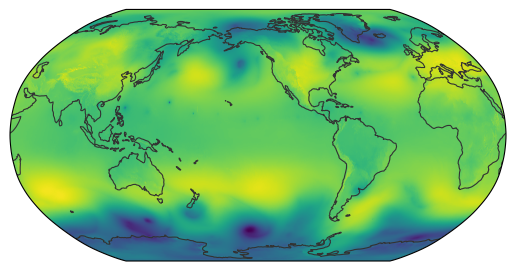

8
<xarray.DataArray 'mslp' (Time: 1, cell: 786432)> Size: 3MB
[786432 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<Figure size 640x480 with 0 Axes>

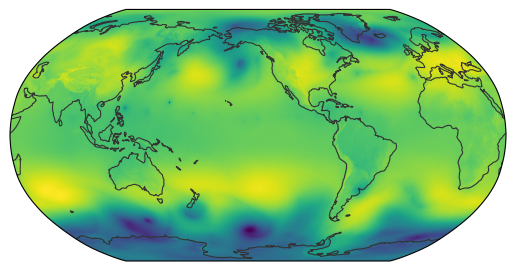

7


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.DataArray 'mslp' (Time: 1, cell: 196608)> Size: 786kB
[196608 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


<Figure size 640x480 with 0 Axes>

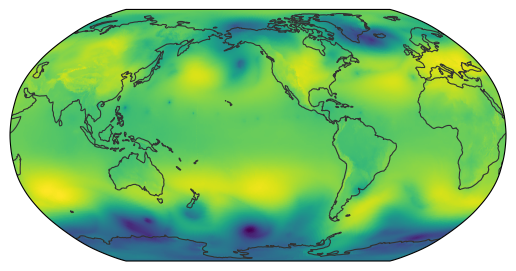

6


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.DataArray 'mslp' (Time: 1, cell: 49152)> Size: 197kB
[49152 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


<Figure size 640x480 with 0 Axes>

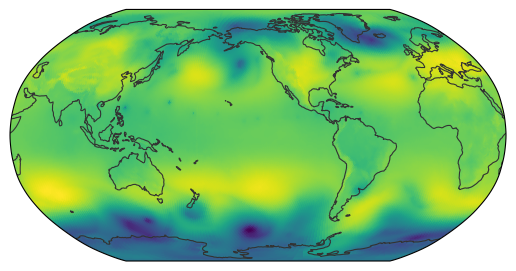

5


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<xarray.DataArray 'mslp' (Time: 1, cell: 12288)> Size: 49kB
[12288 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


<Figure size 640x480 with 0 Axes>

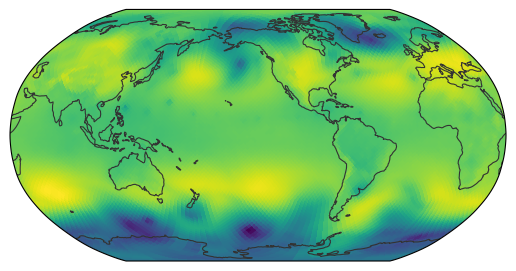

4
<xarray.DataArray 'mslp' (Time: 1, cell: 3072)> Size: 12kB
[3072 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<Figure size 640x480 with 0 Axes>

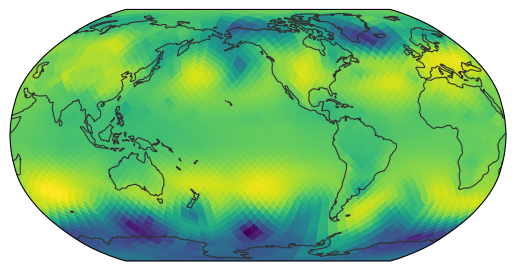

3
<xarray.DataArray 'mslp' (Time: 1, cell: 768)> Size: 3kB
[768 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<Figure size 640x480 with 0 Axes>

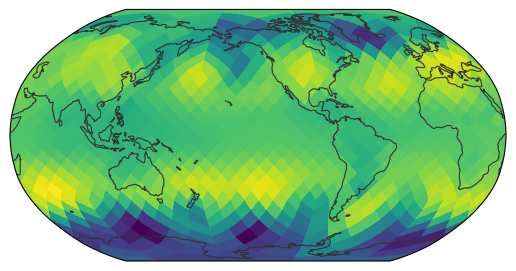

2
<xarray.DataArray 'mslp' (Time: 1, cell: 192)> Size: 768B
[192 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)
/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<Figure size 640x480 with 0 Axes>

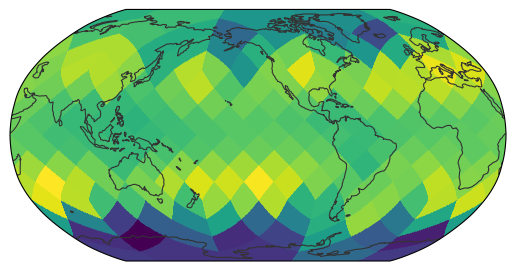

1
<xarray.DataArray 'mslp' (Time: 1, cell: 48)> Size: 192B
[48 values with dtype=float32]
Dimensions without coordinates: Time, cell
Attributes:
    units:      Pa
    long_name:  Mean sea-level pressure


/glade/u/home/brianpm/miniconda3/envs/p12/lib/python3.12/site-packages/zarr/codecs/vlen_utf8.py:99: UserWarning: The codec `vlen-bytes` is currently not part in the Zarr format 3 specification. It may not be supported by other zarr implementations and may change in the future.
  return cls(**configuration_parsed)


<Figure size 640x480 with 0 Axes>

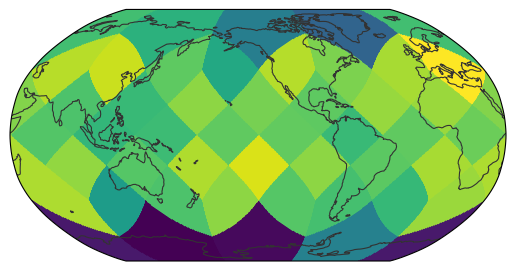

In [47]:
# Read a resulting low-res ZARR and visualize a field
import matplotlib.pyplot as plt
for x in range(zoom-1,0,-1):
    print(x)
    dstmp = xr.open_dataset(f'/glade/derecho/scratch/brianpm/healpix/test_remap_to_hp{x}.zarr')
    print(dstmp['mslp'])
    try:
        egh.healpix_show(dstmp.mslp.isel(Time=0))
        plt.show()
    except:
        print(f"Does not work for zoom = {x}")